In [ ]:
sc

# BIke Sharing

In [ ]:
path = "/Users/akashsoni/Desktop/Bike-Sharing-Dataset/bike.csv"
raw_data = sc.textFile(path)
data_count= raw_data.count()

In [ ]:
records = raw_data.map(lambda x: x.split(","))
first = records.first()
print (first)

In [ ]:
print (data_count)

# Now we have 17379 hourly records,we removed column name already by using unix command
 sed 1d hour.csv > new_hour.csv We will ignore the record ID and raw date columns. 
We will also ignore the casual and registered count target variables and focus on the 
overall count variable, cnt (which is the sum of the other two counts)

We will first cache our dataset, since we will be reading from it many times:

In [5]:
records.cache()

PythonRDD[4] at RDD at PythonRDD.scala:48

now extract each extract each catagorical variable into a binary vector form 
Let's define a function that will extract this mapping from our dataset for a given column:

In [6]:
def get_mapping(rdd, idx):
    return rdd.map(lambda fields: fields[idx]).distinct().zipWithIndex().collectAsMap()

now our function first map the field to its unique values and then uses the zipwithindex 
transformation to formed key value rdd.
where key is the variable and value is the index
We can test our function on the third variable column (index 2):
so i am taking records is rdd and ,2 is index of 3rd variable

Task 3.1

In [7]:
print("mapping of feature catagorical columns: %s" %get_mapping(records,2))

mapping of feature catagorical columns: {'1': 0, '4': 1, '2': 2, '3': 3}


from now we ll apply above function to each categorical column 
for variable index from 2 to 9):

In [8]:
mappings = [get_mapping(records, i) for i in range(2,10)]
catagorical_len = sum(map(len, mappings))
number_len = len(records.first()[11:15])
total_len = number_len + catagorical_len

We have to mappings for each variable, 
and we can see how many values in total we need 
for our binary vector representation:

Task 3 for linear Regression 

In [9]:
print ("Feature vector length for categorical features: %d" % catagorical_len)
print ("Feature vector length for numerical features: %d" % number_len)
print ("Total feature vector length: %d" % total_len)

Feature vector length for categorical features: 57
Feature vector length for numerical features: 4
Total feature vector length: 61


Now creating feature vector for linear model

now again we extract mapping to convert catagorical to binary-encoded features
We will need to import numpy for linear algebra utilities and MLlib's LabeledPoint class to wrap our feature vectors and target variables:

In [10]:
from pyspark.mllib.regression import LabeledPoint
import numpy as np

In [11]:
def ex_features(record):
    catagorical_vector = np.zeros(catagorical_len)
    i = 0
    step = 0
    for field in record[2:9]:
        m = mappings[i]
        idx = m[field]
        catagorical_vector[idx + step] = 1
        i = i + 1
        step = step + len(m)
    number_vector = np.array([float(field) for field in record[10:14]])
    return np.concatenate((catagorical_vector, number_vector))

In [12]:
def extract_label(record):
    return float(record[-1])

ex_features function, we cross through each column in the row of data. 
We find the binary encoding for each single variable in every turn 
from the mappings we created previously
The step variable ensures that the nonzero feature index in the full feature vector is correct
(and is somewhat more efficient than, say, creating many smaller binary vectors and 
 concatenating them). The numeric vector is created directly by first converting the data 
to floating point numbers and wrapping these in a numpy array. The resulting two vectors 
are then concatenated. The extract_label function simply converts the last column variable 
(the count) into a float. With our utility functions defined, we can proceed with extracting 
feature vectors and labels from our data records:

In [13]:
data = records.map(lambda r: LabeledPoint(extract_label(r), ex_features(r)))

Lets check our record in the extracted feature RDD:

In [14]:
first_point = data.first()
print ("Raw data: " + str(first[2:]))
print ("Label: " + str(first_point.label))
print ("Linear Model feature vector:\n" + str(first_point.features))
print ("Linear Model feature vector length: " + str(len(first_point.features)))

Raw data: ['1', '0', '1', '0', '0', '6', '0', '1', '0.24', '0.2879', '0.81', '0', '3', '13', '16']
Label: 16.0
Linear Model feature vector:
[1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.24,0.2879,0.81,0.0]
Linear Model feature vector length: 61


we converted the raw data into a feature vector from the binary categorical and real numeric features, and we have  total vector length of 61 .

Train a linear regression model using Stochastic Gradient
Descent (SGD).
This solves the least squares regression formulation

In [15]:
from pyspark.mllib.regression import LinearRegressionWithSGD

In [16]:
linear_model = LinearRegressionWithSGD.train(data, iterations=10,step=0.1, intercept=False)

/Users/akashsoni/spark/python/pyspark/mllib/regression.py:281: UserWarning: Deprecated in 2.0.0. Use ml.regression.LinearRegression.
  warnings.warn("Deprecated in 2.0.0. Use ml.regression.LinearRegression.")


In [17]:
true_vs_predicted = data.map(lambda p: (p.label, linear_model.predict(p.features)))
print ("Linear Model predictions: " + str(true_vs_predicted.take(5)))

Linear Model predictions: [(16.0, 117.89250386724846), (40.0, 116.2249612319211), (32.0, 116.02369145779235), (13.0, 115.67088016754433), (1.0, 115.56315650834317)]


In [18]:
def squared_error(actual, pred):
    return (pred - actual)**2

In [19]:
def abs_error(actual, pred):
    return np.abs(pred - actual)

In [20]:
def squared_log_error(pred, actual):
    return (np.log(pred + 1) - np.log(actual + 1))**2

In [21]:
li=[]
for i in true_vs_predicted.collect():
    true,pred=i[0],i[1]
    val=(pred - true)**2
    li.append(val)
lenth=len(li)
su=sum(li)
mean=su/lenth
print ("Linear Model - Mean Squared Error: %2.4f" % mean)

Linear Model - Mean Squared Error: 30679.4539


In [22]:
targets = records.map(lambda r: float(r[-1])).collect()

We will now create a plot of the target variable 
distribution in the following piece of code:



In [23]:
import pylab

In [24]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['mean', 'pylab']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


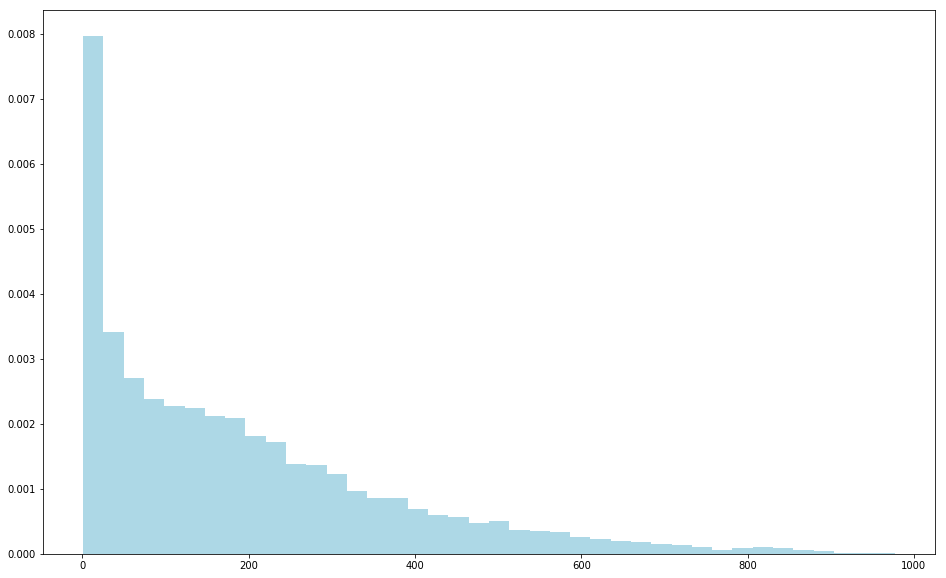

In [25]:
hist(targets, bins=40, color='lightblue', normed=True)

fig = matplotlib.pyplot.gcf()

fig.set_size_inches(16, 10)

We will apply a log transformation to the following target variable and plot a histogram of the log-transformed values:

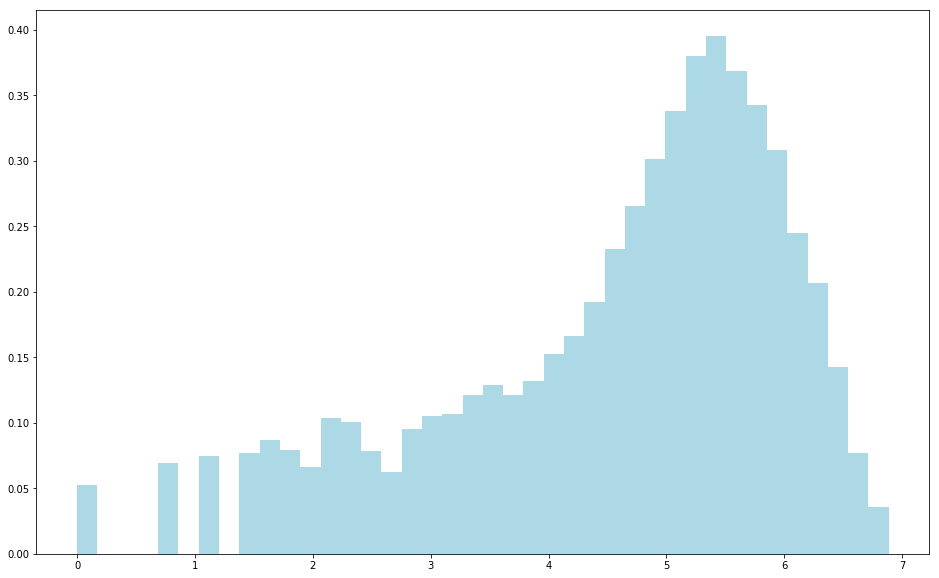

In [26]:
log_targets = records.map(lambda r: np.log(float(r[-1]))).collect()

hist(log_targets, bins=40, color='lightblue', normed=True)

fig = matplotlib.pyplot.gcf()

fig.set_size_inches(16, 10)

Impact of training on log-transformed targets

So, does applying these transformations have any 
impact on model performance? 
Let's evaluate the various metrics we used previously on log-transformed data as an example.

We will do this first for the linear model by applying the numpy log function to the label 
field of each LabeledPoint RDD. Here, we will only transform the target variable, and 
we will not apply any transformations to the features:

In [27]:
data_log = data.map(lambda lp: LabeledPoint(np.log(lp.label), lp.features))


We will then train a model on this transformed data and 
form the RDD of predicted versus true values:

In [28]:
model_log = LinearRegressionWithSGD.train(data_log, iterations=10, step=0.1)

/Users/akashsoni/spark/python/pyspark/mllib/regression.py:281: UserWarning: Deprecated in 2.0.0. Use ml.regression.LinearRegression.
  warnings.warn("Deprecated in 2.0.0. Use ml.regression.LinearRegression.")


we have transformed the target variable, the predictions of the model will be on the log scale,
as will the target values of the transformed dataset. Therefore, in order to use our model and 
evaluate its performance, we must first transform the log data back into the original scale by 
taking the exponent of both the predicted and true values using the numpy exp function.
We will show you how to do this in the code here:

In [29]:
true_vs_predicted_log = data_log.map(lambda p: (np.exp(p.label), np.exp(model_log.predict(p.features))))

In [30]:
nn=[]
ab=[]
s_log=[]
for i in true_vs_predicted_log.collect():
    real,predict=i[0],i[1]
    value=(predict - real)**2
    value1=np.abs(predict - real)
    value2=(np.log(predict + 1) - np.log(real + 1))**2
    nn.append(value)
    ab.append(value1)
    s_log.append(value2)
value_len=len(nn)
print( value_len)
ss=sum(nn)
t=ss/value_len
ab_sum=sum(ab)
ab_mean=ab_sum/value_len
s_log_sum=sum(s_log)
s_log_mean=np.sqrt(s_log_sum/value_len)
print ("log - Mean Squared Error: %2.4f" % t)
print("log - Mean Absolue Error: %2.4f" % ab_mean)
print("Root Mean Squared Log Error: %2.4f" % s_log_mean)


17379
log - Mean Squared Error: 50685.5559
log - Mean Absolue Error: 155.2955
Root Mean Squared Log Error: 1.5411


In [31]:
print ("Non log-transformed predictions:\n" + str(true_vs_predicted.take(3)))

print ("Log-transformed predictions:\n" + str(true_vs_predicted_log.take(3)))

Non log-transformed predictions:
[(16.0, 117.89250386724846), (40.0, 116.2249612319211), (32.0, 116.02369145779235)]
Log-transformed predictions:
[(15.999999999999998, 28.080291845456212), (40.0, 26.959480191001784), (32.0, 26.65472562945802)]


# Tuning model parameters

So far in this chapter, we have illustrated the concepts of model training and 
evaluation for MLlib's regression models by training and testing on the same dataset. 
We will now use a similar cross-validation approach that we used previously to evaluate 
the effect on performance of different parameter settings for our models

One relatively easy way to do this is by first taking a random sample of, say, 20 percent of our data as our test set. We will then define our training set as the elements of the original RDD that are not in the test set RDD.

# Spliting data into training and test data for cross validation

In [32]:
train, test = data.randomSplit([0.8, 0.2], seed=12345)

In [33]:
train_size=train.count()

In [34]:
test_size=test.count()

In [35]:
print ("Training data size: %d" % train_size)

Training data size: 13834


In [36]:
print ("Test data size: %d" % test_size)

Test data size: 3545


In [37]:
print ("Train + Test size : %d" % (train_size + test_size))

Train + Test size : 17379


We can confirm that we now have two distinct datasets that add up to the original dataset in total:

Training data size: 13934

Test data size: 3545

Total data size: 17379

Train + Test size : 17379



# The impact of parameter settings for linear models

Now that we have prepared our training and test sets, we are ready to investigate the impact of different parameter settings on model performance. We will first carry out this evaluation for the linear model. We will create a convenience function to evaluate the relevant performance metric by training the model on the training set and evaluating it on the test set for different parameter settings.

We will use the RMSLE evaluation metric, as it is the one used in the Kaggle competition with this dataset, and this allows us to compare our model results against the competition leaderboard to see how we perform.

The evaluation function is defined here:

In [38]:
def squared_log_error(pred, actual):
    return (np.log(pred + 1) - np.log(actual + 1))**2

In [39]:
def evaluate(train, test, iterations, step, regParam, regType, intercept):

    model = LinearRegressionWithSGD.train(train, iterations, step, regParam=regParam, regType=regType, intercept=intercept)

    tp = test.map(lambda p: (p.label, model.predict(p.features)))
    
    new_val=[]
    for i in tp.collect():
        actual=i[0]
        pred=i[1]
        va=(np.log(pred + 1) - np.log(actual + 1))**2
        new_val.append(va)
    lenth=len(new_val)
    s_new_val=sum(new_val)
    mean_new_val=s_new_val/lenth
    rmsle=np.sqrt(mean_new_val)
    return rmsle

# Iterations

As we saw when evaluating our classification models, we generally expect that a model trained with SGD will achieve better performance as the number of iterations increases, although the increase in performance will slow down as the number of iterations goes above some minimum number. Note that here, we will set the step size to 0.01 to better illustrate the impact at higher iteration numbers:

In [40]:
params = [1, 5, 10, 20, 50, 100]

metrics = [evaluate(train, test, param, 0.01, 0.0, 'l2', False) for param in params]

print (params)

print (metrics)

/Users/akashsoni/spark/python/pyspark/mllib/regression.py:281: UserWarning: Deprecated in 2.0.0. Use ml.regression.LinearRegression.
  warnings.warn("Deprecated in 2.0.0. Use ml.regression.LinearRegression.")


[1, 5, 10, 20, 50, 100]
[2.9204455616016656, 2.0695085222669265, 1.79815897170536, 1.594156705081269, 1.43308397524522, 1.3878383528812235]


Here, we will use the matplotlib library to plot a graph of the RMSLE metric against the number of iterations. We will use a log scale for the x axis to make the output easier to visualize:

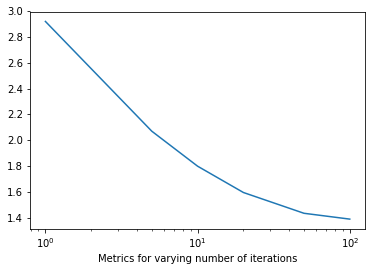

In [41]:
plot(params, metrics)

fig = matplotlib.pyplot.gcf()
pyplot.xlabel('Metrics for varying number of iterations')
pyplot.xscale('log')

# Step size

We will perform a similar analysis for step size in the following code:

In [42]:
params = [0.01, 0.025, 0.05, 0.1, 1.0]

In [43]:
metrics = [evaluate(train, test, 10, param, 0.0, 'l2', False) for param in params]

/Users/akashsoni/spark/python/pyspark/mllib/regression.py:281: UserWarning: Deprecated in 2.0.0. Use ml.regression.LinearRegression.
  warnings.warn("Deprecated in 2.0.0. Use ml.regression.LinearRegression.")
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in log
  # This is added back by InteractiveShellApp.init_path()


In [44]:
print (params)
print (metrics)

[0.01, 0.025, 0.05, 0.1, 1.0]
[1.79815897170536, 1.432660677663247, 1.3921046531899715, 1.463373357714063, nan]


Now, we can see why we avoided using the default step size when training the linear model originally. The default is set to 1.0, which, in this case, results in a nan output for the RMSLE metric. This typically means that the SGD model has converged to a very poor local minimum in the error function that it is optimizing. This can happen when the step size is relatively large, as it is easier for the optimization algorithm to overshoot good solutions.

We can also see that for low step sizes and a relatively low number of iterations (we used 10 here), the model performance is slightly poorer. However, in the preceding Iterations section, we saw that for the lower step-size setting, a higher number of iterations will generally converge to a better solution.

Generally speaking, setting step size and number of iterations involves a trade-off. A lower step size means that convergence is slower but slightly more assured. However, it requires a higher number of iterations, which is more costly in terms of computation and time, in particular at a very large scale.

Selecting the best parameter settings can be an intensive process that involves training a model on many combinations of parameter settings and selecting the best outcome. Each instance of model training involves a number of iterations, so this process can be very expensive and time consuming when performed on very large datasets.

The output is plotted here, again using a log scale for the step-size axis:

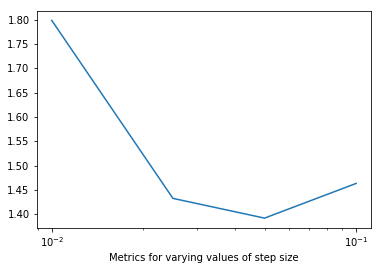

In [45]:
plot(params, metrics)

fig = matplotlib.pyplot.gcf()
pyplot.xlabel('Metrics for varying values of step size')
pyplot.xscale('log')

# L2 regularization

egularization has the effect of penalizing model complexity in the form of an additional loss term that is a function of the model weight vector. L2 regularization penalizes the L2-norm of the weight vector, while L1 regularization penalizes the L1-norm.

We expect training set performance to deteriorate with increasing regularization, as the model cannot fit the dataset well. However, we would also expect some amount of regularization that will result in optimal generalization performance as evidenced by the best performance on the test set.

In [46]:
params = [0.0, 0.01, 0.1, 1.0, 5.0, 10.0, 20.0]

metrics = [evaluate(train, test, 10, 0.1, param, 'l2', False) for param in params]

print (params)

print (metrics)

/Users/akashsoni/spark/python/pyspark/mllib/regression.py:281: UserWarning: Deprecated in 2.0.0. Use ml.regression.LinearRegression.
  warnings.warn("Deprecated in 2.0.0. Use ml.regression.LinearRegression.")


[0.0, 0.01, 0.1, 1.0, 5.0, 10.0, 20.0]
[1.463373357714063, 1.4627638795194882, 1.457389998406437, 1.414347928269498, 1.4006915016046428, 1.5458042588519074, 1.8520326400407603]


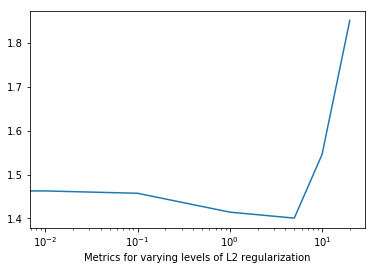

In [47]:
plot(params, metrics)

fig = matplotlib.pyplot.gcf()
pyplot.xlabel('Metrics for varying levels of L2 regularization')
pyplot.xscale('log')

# L1 regularization

We can apply the same approach for differing levels of L1 regularization:


In [48]:
params = [0.0, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]

metrics = [evaluate(train, test, 10, 0.1, param, 'l1', False) for param in params]

print (params)

print (metrics)

/Users/akashsoni/spark/python/pyspark/mllib/regression.py:281: UserWarning: Deprecated in 2.0.0. Use ml.regression.LinearRegression.
  warnings.warn("Deprecated in 2.0.0. Use ml.regression.LinearRegression.")


[0.0, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
[1.463373357714063, 1.4633409680931317, 1.4630506454349392, 1.4603658739928238, 1.4355688529629576, 1.7677660966171576, 4.800777158151935]


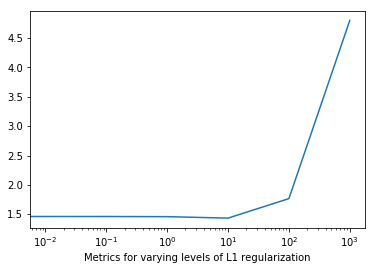

In [49]:
plot(params, metrics)

fig = matplotlib.pyplot.gcf()
pyplot.xlabel('Metrics for varying levels of L1 regularization')
pyplot.xscale('log')

Using L1 regularization can encourage sparse weight vectors. Does this hold true in this case? We can find out by examining the number of entries in the weight vector that are zero, with increasing levels of regularization:

In [50]:
model_l1 = LinearRegressionWithSGD.train(train, 10, 0.1, regParam=1.0, regType='l1', intercept=False)

model_l1_10 = LinearRegressionWithSGD.train(train, 10, 0.1, regParam=10.0, regType='l1', intercept=False)

model_l1_100 = LinearRegressionWithSGD.train(train, 10, 0.1, regParam=100.0, regType='l1', intercept=False)

print ("L1 (1.0) number of zero weights: " + str(sum(model_l1.weights.array == 0)))

print ("L1 (10.0) number of zeros weights: " + str(sum(model_l1_10.weights.array == 0)))

print ("L1 (100.0) number of zeros weights: " + str(sum(model_l1_100.weights.array == 0)))

/Users/akashsoni/spark/python/pyspark/mllib/regression.py:281: UserWarning: Deprecated in 2.0.0. Use ml.regression.LinearRegression.
  warnings.warn("Deprecated in 2.0.0. Use ml.regression.LinearRegression.")


L1 (1.0) number of zero weights: 4
L1 (10.0) number of zeros weights: 33
L1 (100.0) number of zeros weights: 58


# Intercept

The final parameter option for the linear model is whether to use an intercept or not. An intercept is a constant term that is added to the weight vector and effectively accounts for the mean value of the target variable. If the data is already centered or normalized, an intercept is not necessary; however, it often does not hurt to use one in any case.

We will evaluate the effect of adding an intercept term to the model here:

In [51]:
params = [False, True]

metrics = [evaluate(train, test, 10, 0.1, 1.0, 'l2', param) for param in params]

print (params)

print (metrics)

/Users/akashsoni/spark/python/pyspark/mllib/regression.py:281: UserWarning: Deprecated in 2.0.0. Use ml.regression.LinearRegression.
  warnings.warn("Deprecated in 2.0.0. Use ml.regression.LinearRegression.")


[False, True]
[1.414347928269498, 1.4431958566566532]


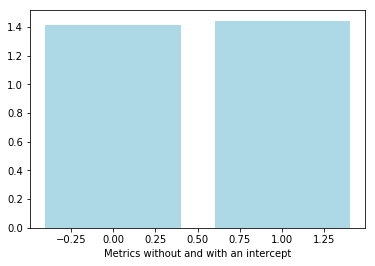

In [52]:
bar(params, metrics, color='lightblue')
pyplot.xlabel('Metrics without and with an intercept')
fig = matplotlib.pyplot.gcf()

# Decision Tree

Creating feature vectors for the decision tree

As we have seen, decision tree models typically work on raw features (that is, it is not required to convert categorical features into a binary vector encoding; they can, instead, be used directly). Therefore, we will create a separate function to extract the decision tree feature vector, which simply converts all the values to floats and wraps them in a numpy array:

In [53]:
def extract_features_dt(record):
    return np.array(list(map(float, record[2:14])))

In [54]:
def extract_label(record):
    return float(record[-1])

In [55]:
data_dt = records.map(lambda r: LabeledPoint(extract_label(r),extract_features_dt(r)))


In [56]:
first_point_dt = data_dt.first()
print ("Decision Tree feature vector: " + str(first_point_dt.features))
print ("Decision Tree feature vector length: " + str(len(first_point_dt.features)))

Decision Tree feature vector: [1.0,0.0,1.0,0.0,0.0,6.0,0.0,1.0,0.24,0.2879,0.81,0.0]
Decision Tree feature vector length: 12


In [57]:

from pyspark.mllib.tree import DecisionTree

In [58]:
dt_model = DecisionTree.trainRegressor(data_dt,{})
preds = dt_model.predict(data_dt.map(lambda p: p.features))
actual = data.map(lambda p: p.label)
true_vs_predicted_dt = actual.zip(preds)
print ("Decision Tree predictions: " + str(true_vs_predicted_dt.take(5)))
print ("Decision Tree depth: " + str(dt_model.depth()))
print ("Decision Tree number of nodes: " + str(dt_model.numNodes()))

Decision Tree predictions: [(16.0, 54.913223140495866), (40.0, 54.913223140495866), (32.0, 53.171052631578945), (13.0, 14.284023668639053), (1.0, 14.284023668639053)]
Decision Tree depth: 5
Decision Tree number of nodes: 63


We will use the same approach for the decision tree model, using the true_vs_predicted_dt RDD:

In [59]:
nn=[]
ab=[]
s_log=[]
for i in true_vs_predicted_dt.collect():
    real,predict=i[0],i[1]
    value=(predict - real)**2
    value1=np.abs(predict - real)
    value2=(np.log(predict + 1) - np.log(real + 1))**2
    nn.append(value)
    ab.append(value1)
    s_log.append(value2)
value_len=len(nn)
print( value_len)
ss=sum(nn)
t=ss/value_len
ab_sum=sum(ab)
ab_mean=ab_sum/value_len
s_log_sum=sum(s_log)
s_log_mean=np.sqrt(s_log_sum/value_len)
print ("log - Mean Squared Error: %2.4f" % t)
print("log - Mean Absolue Error: %2.4f" % ab_mean)
print("Root Mean Squared Log Error: %2.4f" % s_log_mean)

17379
log - Mean Squared Error: 11611.4860
log - Mean Absolue Error: 71.1502
Root Mean Squared Log Error: 0.6251


# Impact of training on log-transformed targets

We will perform the same analysis for the decision tree model:

In [60]:
data_dt_log = data_dt.map(lambda lp: LabeledPoint(np.log(lp.label), lp.features))

dt_model_log = DecisionTree.trainRegressor(data_dt_log,{})

preds_log = dt_model_log.predict(data_dt_log.map(lambda p: p.features))

actual_log = data_dt_log.map(lambda p: p.label)


In [61]:
new=actual_log.zip(preds_log)

In [62]:
new.take(5)

[(2.772588722239781, 3.6251613906330347),
 (3.6888794541139363, 3.6251613906330347),
 (3.4657359027997265, 1.985090627799027),
 (2.5649493574615367, 1.985090627799027),
 (0.0, 1.985090627799027)]

In [63]:
true_vs_predicted_dt_log=[]
for val in new.collect():
    t,p=val[0],val[1]
    x=np.exp(t),np.exp(p)
    true_vs_predicted_dt_log.append(x)

In [64]:
nn=[]
ab=[]
s_log=[]
for i in true_vs_predicted_dt_log:
    real,predict=i[0],i[1]
    value=(predict - real)**2
    value1=np.abs(predict - real)
    value2=(np.log(predict + 1) - np.log(real + 1))**2
    nn.append(value)
    ab.append(value1)
    s_log.append(value2)
value_len=len(nn)
print( value_len)
ss=sum(nn)
t=ss/value_len
ab_sum=sum(ab)
ab_mean=ab_sum/value_len
s_log_sum=sum(s_log)
s_log_mean=np.sqrt(s_log_sum/value_len)
print ("log - Mean Squared Error: %2.4f" % t)
print("log - Mean Absolue Error: %2.4f" % ab_mean)
print("Root Mean Squared Log Error: %2.4f" % s_log_mean)
print ("Non log-transformed predictions:\n" + str(true_vs_predicted_dt.take(3)))


17379
log - Mean Squared Error: 14781.5760
log - Mean Absolue Error: 76.4131
Root Mean Squared Log Error: 0.6406
Non log-transformed predictions:
[(16.0, 54.913223140495866), (40.0, 54.913223140495866), (32.0, 53.171052631578945)]


# CROSS VALIDATION for the decision tree

In [65]:
train_dt, test_dt = data_dt.randomSplit([0.8, 0.2], seed=12345)

The impact of parameter settings for the decision tree

In [66]:
def evaluate_dt(train, test, maxDepth, maxBins):

    model = DecisionTree.trainRegressor(train, {}, impurity='variance', maxDepth=maxDepth, maxBins=maxBins)

    preds = model.predict(test.map(lambda p: p.features))

    actual = test.map(lambda p: p.label)

    tp = actual.zip(preds)
    new_val=[]
    for i in tp.collect():
        actual=i[0]
        pred=i[1]
        va=(np.log(pred + 1) - np.log(actual + 1))**2
        new_val.append(va)
    lenth=len(new_val)
    s_new_val=sum(new_val)
    mean_new_val=s_new_val/lenth
    rmsle=np.sqrt(mean_new_val)
    return rmsle
    

# Tree depth

We would generally expect performance to increase with more complex trees (that is, trees of greater depth). Having a lower tree depth acts as a form of regularization, and it might be the case that as with L2 or L1 regularization in linear models, there is a tree depth that is optimal with respect to the test set performance.

Here, we will try to increase the depths of trees to see what impact they have on test set RMSLE, keeping the number of bins at the default level of 32:

[1, 2, 3, 4, 5, 10, 20]
[1.0009455704281573, 0.9071380409401831, 0.8083991513814845, 0.7316093046671605, 0.6252775817287765, 0.43025139584509925, 0.4467589576168234]


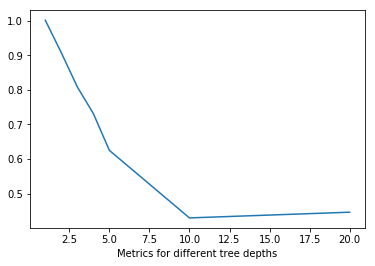

In [67]:
params = [1, 2, 3, 4, 5, 10, 20]

metrics = [evaluate_dt(train_dt, test_dt, param, 32) for param in params]

print (params)

print (metrics)

plot(params, metrics)
pyplot.xlabel('Metrics for different tree depths')
fig = matplotlib.pyplot.gcf()

# Maximum bins

Finally, we will perform our evaluation on the impact of setting the number of bins for the decision tree. As with the tree depth, a larger number of bins should allow the model to become more complex and might help performance with larger feature dimensions. After a certain point, it is unlikely that it will help any more and might, in fact, hinder performance on the test set due to over-fitting:

[2, 4, 8, 16, 32, 64, 100]
[1.2692079792473667, 0.8059355903824542, 0.7446332199349833, 0.5969914946964172, 0.6252775817287765, 0.6252775817287765, 0.6252775817287765]


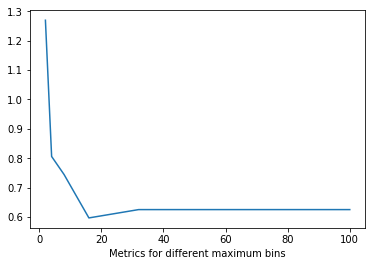

In [68]:
params = [2, 4, 8, 16, 32, 64, 100]

metrics = [evaluate_dt(train_dt, test_dt, 5, param) for param in params]

print (params)

print (metrics)

plot(params, metrics)
pyplot.xlabel('Metrics for different maximum bins')
fig = matplotlib.pyplot.gcf()

# Gradient BOOSTED TREE

In [69]:
from pyspark.mllib.tree import GradientBoostedTrees, GradientBoostedTreesModel


In [70]:
data_gbt = records.map(lambda r: LabeledPoint(extract_label(r),extract_features_dt(r)))

In [74]:
(trainingData, testData) = data_gbt.randomSplit([0.7, 0.3])

In [75]:
model = GradientBoostedTrees.trainRegressor(trainingData,
                                            categoricalFeaturesInfo={}, numIterations=3)
preds = model.predict(testData.map(lambda p: p.features))
actual = testData.map(lambda p: p.label)
true_vs_predicted_GBT = actual.zip(preds)
print ("Gradient BOOSTED predictions: " + str(true_vs_predicted_GBT.take(5)))



Gradient BOOSTED predictions: [(32.0, 21.043168257608315), (1.0, 21.043168257608315), (2.0, 20.78800044083532), (14.0, 122.94779932705194), (36.0, 122.94779932705194)]


In [77]:
nn=[]
ab=[]
s_log=[]
for i in true_vs_predicted_GBT.collect():
    real,predict=i[0],i[1]
    value=(predict - real)**2
    value1=np.abs(predict - real)
    value2=(np.log(predict + 1) - np.log(real + 1))**2
    nn.append(value)
    ab.append(value1)
    s_log.append(value2)
value_len=len(nn)
print( value_len)
ss=sum(nn)
t=ss/value_len
ab_sum=sum(ab)
ab_mean=ab_sum/value_len
s_log_sum=sum(s_log)

s_log_mean=np.sqrt(s_log_sum/value_len)
print ("log - Mean Squared Error: %2.4f" % t)
print("log - Mean Absolue Error: %2.4f" % ab_mean)
print("Root Mean Squared Log Error: %2.4f" % s_log_mean)

5274
log - Mean Squared Error: 13350.5537
log - Mean Absolue Error: 80.6329
Root Mean Squared Log Error: 0.7853


In [146]:
def evaluate_dt(trainingData,categoricalFeaturesInfo, loss, numIterations, maxDepth, maxBins):

    model = GradientBoostedTrees.trainRegressor(trainingData,categoricalFeaturesInfo, loss,numIterations,maxDepth=maxDepth, maxBins=maxBins)

    preds = model.predict(testData.map(lambda p: p.features))

    actual = testData.map(lambda p: p.label)

    tp = actual.zip(preds)
    new_val=[]
    for i in tp.collect():
        actual=i[0]
        pred=i[1]
        va=(np.log(pred + 1) - np.log(actual + 1))**2
        new_val.append(va)
    lenth=len(new_val)
    s_new_val=sum(new_val)
    mean_new_val=s_new_val/lenth
    rmsle=np.sqrt(mean_new_val)
    return rmsle

# Gradient boost tree Iteration

[2, 4, 8, 16, 32, 64, 100]
[0.8134345004020272, 0.8127317477436009, 0.8113281083567387, 0.808549849515173, 0.8031158350948435, 0.7927594410577089, 0.7820605621004253]


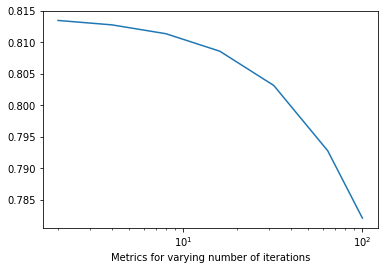

In [149]:
params = [2, 4, 8, 16, 32, 64, 100]

metrics = [evaluate_dt(trainingData, {},'leastAbsoluteError', param,3, 32) for param in params]

print (params)

print (metrics)

plot(params, metrics)

fig = matplotlib.pyplot.gcf()
pyplot.xlabel('Metrics for varying number of iterations')
pyplot.xscale('log')

[2, 4, 8, 16, 32, 64, 100]
[1.2841906521739503, 0.8628661947197386, 0.8241029850613957, 0.8089035578039226, 0.810628070877074, 0.810628070877074, 0.810628070877074]


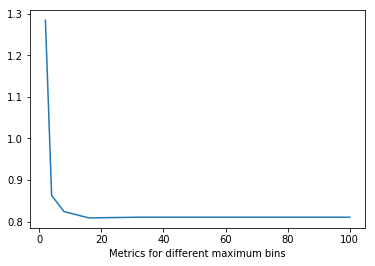

In [148]:
params = [2, 4, 8, 16, 32, 64, 100]

metrics = [evaluate_dt(trainingData, {},'leastAbsoluteError',10,3, param) for param in params]

print (params)

print (metrics)

plot(params, metrics)
pyplot.xlabel('Metrics for different maximum bins')
fig = matplotlib.pyplot.gcf()